In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from lightfm.evaluation import precision_at_k
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lv0sg0mz because the default path (/home/i313924/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
THREADS = 8

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/warp_model_1000_epochs_slim_features.pkl')

In [4]:
item_features = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_item_features.pkl')

## ABX utils

In [5]:
def analyse_ABX(path, tsne = None, pca = None):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 100))
    B = np.zeros((10000, 100))
    X = np.zeros((10000, 100))

    for i, test in tqdm(abx_tests.iterrows()):
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X)**2).sum(axis=1)
    dist_B = ((B - X)**2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in tqdm(range(10000)):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X)**2).sum(axis=1)
        dist_pca_B  = ((pca_B - pca_X)**2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    if tsne is not None:
        tsne_A = np.zeros((10000, 2))
        tsne_B = np.zeros((10000, 2))
        tsne_X = np.zeros((10000, 2))

        for i, test in tqdm(abx_tests.iterrows()):
            tsne_A[i, :] = tsne.loc[test["A"]]
            tsne_B[i, :] = tsne.loc[test["B"]]
            tsne_X[i, :] = tsne.loc[test["X"]]


        dist_tsne_A = ((tsne_A - tsne_X)**2).sum(axis=1)
        dist_tsne_B  = ((tsne_B - tsne_X)**2).sum(axis=1)

        cos_dist_tsne_A = np.zeros(10000)
        cos_dist_tsne_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_tsne_A[i] = spatial.distance.cosine(tsne_A[i, :], tsne_X[i, :])
            cos_dist_tsne_B[i] = spatial.distance.cosine(tsne_B[i, :], tsne_X[i, :])

    print("Eucl:")
    print("Score: ", (dist_A < dist_B).mean())
    if pca is not None:
        print("PCA score: ", (dist_pca_A < dist_pca_B).mean())
        print("PCA distance match: ", ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (dist_tsne_A < dist_tsne_B).mean())
        print("tSNE distance match: ", ((dist_A < dist_B) == (dist_tsne_A < dist_tsne_B)).mean())

    print("Cos:",)
    print("Score: ", (cos_dist_A < cos_dist_B).mean())
    if pca is not None:
        print("PCA score: ", (cos_dist_pca_A < cos_dist_pca_B).mean())
        print("PCA distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_pca_A < cos_dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (cos_dist_tsne_A < cos_dist_tsne_B).mean())
        print("tSNE distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_tsne_A < dist_tsne_B)).mean())

In [17]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset_features.pkl')

item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
items_embeddings = pd.DataFrame(model.get_item_representations(item_features)[1])
items_embeddings = items_embeddings.rename(index=item_mapping)

pca = PCA(n_components=2)
pca.fit(items_embeddings)

PCA(n_components=2)

## ABX (only popular)

In [18]:
analyse_ABX('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', pca=pca)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Eucl:
Score:  0.7463
PCA score:  0.7429
PCA distance match:  0.7202
Cos:
Score:  0.7234
PCA score:  0.7306
PCA distance match:  0.6518


## Embeddings PCA

In [19]:
reduced_item_embeddings = pd.DataFrame(pca.transform(items_embeddings))

In [20]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}

In [21]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [22]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [23]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [24]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


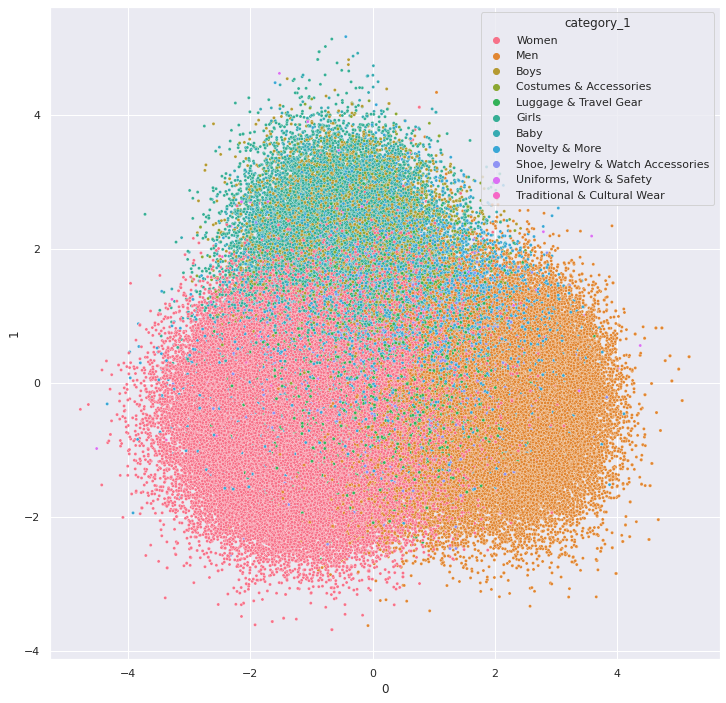

In [25]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

[(-5.0, 5.0), (-5.0, 5.0)]

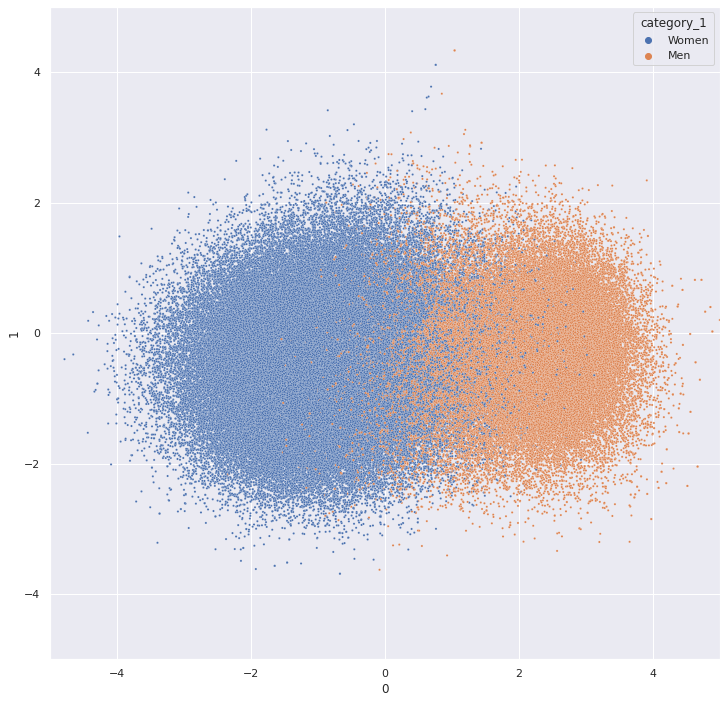

In [26]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5).set(xlim=(-5,5),ylim=(-5,5))

In [27]:
women_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Women']
men_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Men']

[(-5.0, 5.0), (-5.0, 5.0)]

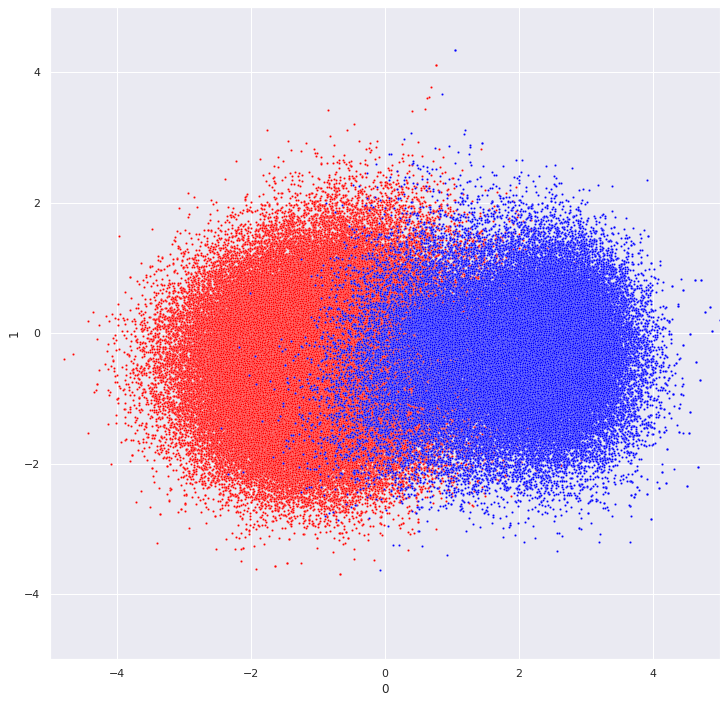

In [28]:
sns.scatterplot(x='0', y='1', data=women_embeddings, color='red', s=5).set(xlim=(-5,5),ylim=(-5,5))
sns.scatterplot(x='0', y='1', data=men_embeddings, color='blue', s=5).set(xlim=(-5,5),ylim=(-5,5))

[(-5.0, 5.0), (-5.0, 5.0)]

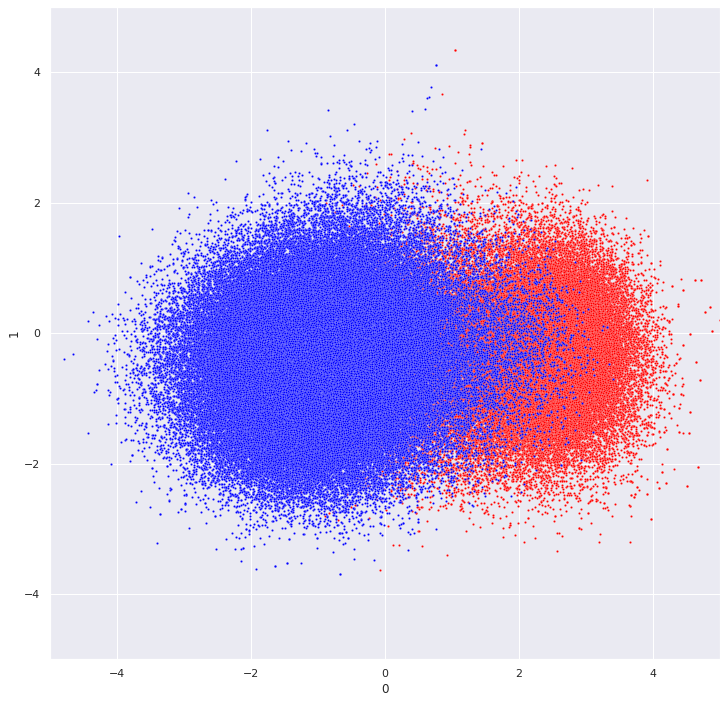

In [29]:
sns.scatterplot(x='0', y='1', data=men_embeddings, color='red', s=5).set(xlim=(-5,5),ylim=(-5,5))
sns.scatterplot(x='0', y='1', data=women_embeddings, color='blue', s=5).set(xlim=(-5,5),ylim=(-5,5))